# [ GLOW ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW, AUTO_GLOW
from core.fisher_utils_GLOW import Calculate_fisher_GLOW_ekfac, Calculate_score_GLOW_ekfac
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# fix a random seed
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# GLOW - CIFAR10 & FMNIST

## [1] Load the model & Parameter Selection

In [2]:
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()
modules = []

## [2] Compute ROSE via EKFAC

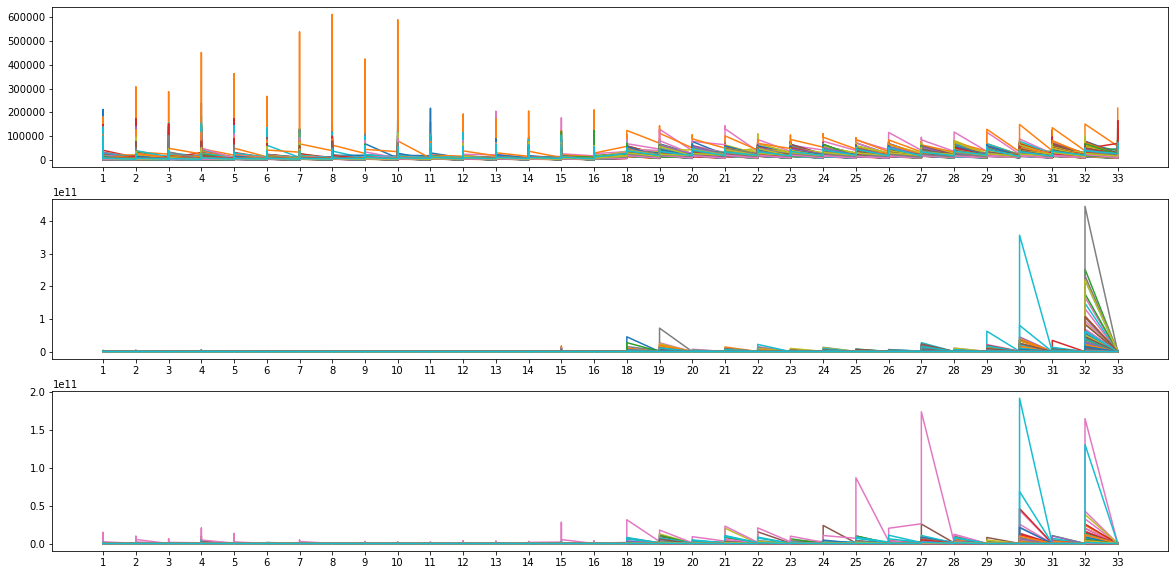

In [13]:
dfs = {}
for key in train_score.keys():
    train_score[key] = np.array(train_score[key]).reshape(-1)
    
df = pd.DataFrame(train_score)
for col in df.columns:
    try:
        if col.split('.')[3] != 'block':
            df = df.drop(col, axis=1)
    except:
        df = df.drop(col, axis=1)
    
cols = []
for column in df.columns:
    cols.append(column.split('.')[2])
df.columns = cols
dfs['train'] = df

result2 = {}
for ood in result.keys():
    result2[ood] = {}
    for key in result[ood].keys():
        result[ood][key] = result[ood][key].reshape(-1)
        result2[ood][key] = result[ood][key] * std[key] + mean[key]

    df = pd.DataFrame(result2[ood])
    for col in df.columns:
        try:
            if col.split('.')[3] != 'block':
                df = df.drop(col, axis=1)
        except:
            df = df.drop(col, axis=1)

    cols = []
    for column in df.columns:
        cols.append(column.split('.')[2])
    df.columns = cols
    dfs[ood] = df
    
    
fig = plt.figure(figsize=(20, 10))
for i, key in enumerate(['train', 'fmnist', 'mnist']):
    df = dfs[key]
    ax = fig.add_subplot(3, 1, i+1)
    for i in range(len(df)):
        ax.plot(df.iloc[i, :], label=key)
    #ax.set_ylim([0, 10000000])
plt.show()

In [3]:
method = 'ekfac(max)'
auroc = {}
SCOREs = {}

U_A, U_B, S, mean, std, train_score = Calculate_fisher_GLOW_ekfac(model, opt, max_iter=1000, select_modules=modules, seed=2021)

Files already downloaded and verified


Calculate A, B:   0%|                                                                      | 0/50000 [00:00<?, ?step/s]C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:770: UserWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not take as input a "
C:\Users\shinypond\.conda\envs\torch\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the f

Files already downloaded and verified


Calculate Fisher Inverse:   2%|▉                                               | 999/50000 [01:45<1:26:34,  9.43step/s]


Files already downloaded and verified


Calculate Score of cifar10(train):   2%|▊                                      | 999/50000 [01:57<1:36:11,  8.49step/s]


In [4]:
result = {}
for ood in opt.ood_list:
    score = Calculate_score_GLOW_ekfac(model, opt, U_A, U_B, S, ood, max_iter=1, seed=2021)
    result[ood] = {}
    temp = []
    for name in score.keys():
        a = np.array(score[name])
        a = (a - mean[name]) / std[name]  
        result[ood][name] = a
        #temp.append(a) 
        #plt.figure()
        #plt.title(f'{opt.train_dist}_{ood}_{name}')
        #plt.hist(a, bins=100)
        #plt.show()
    #score = np.max(np.concatenate(temp, 1), 1)
    #SCOREs[ood] = score
    #args = [SCOREs[opt.train_dist], SCOREs[ood]]
    #labels = [opt.train_dist, ood]
    #auroc[ood] = AUROC(*args, labels=labels, verbose=False)
#auroc

Files already downloaded and verified


Calculate Score of cifar10:   0%|                                                          | 0/10000 [00:00<?, ?step/s]

['1', 'invconv'] torch.Size([12, 12]) 297.1639709472656 103.341064453125
1288.9794921875 25.356903076171875
['1', 'block'] torch.Size([400, 54]) 6.147680282592773 0.3227415084838867
29.63795280456543 0.08302538841962814
['1', 'block'] torch.Size([400, 400]) 6.3267998695373535 0.025891263037919998
13.587101936340332 0.01802501268684864
['1', 'block'] torch.Size([12, 3601]) 41.4783821105957 0.17602527141571045
157.8430633544922 0.15739934146404266
['2', 'invconv'] torch.Size([12, 12]) 364.0127258300781 67.0821304321289
890.2564697265625 19.814647674560547
['2', 'block'] torch.Size([400, 54]) 6.56405782699585 0.20031973719596863
19.436115264892578 0.056722238659858704
['2', 'block'] torch.Size([400, 400]) 1.8723583221435547 0.02077542431652546
3.605376958847046 0.013486556708812714
['2', 'block'] torch.Size([12, 3601]) 35.032474517822266 0.24139493703842163
159.64295959472656 0.16086536645889282
['3', 'invconv'] torch.Size([12, 12]) 139.81817626953125 25.149301528930664
346.2471618652344 

Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score of mnist:   0%|                                                            | 0/10000 [00:00<?, ?step/s]

['1', 'invconv'] torch.Size([12, 12]) 588.19677734375 189.97251892089844
2310.0458984375 51.30960464477539
['1', 'block'] torch.Size([400, 54]) 12.079065322875977 0.5748825669288635
58.07122802734375 0.13269321620464325
['1', 'block'] torch.Size([400, 400]) 12.423699378967285 0.029522713273763657
23.490867614746094 0.024106550961732864
['1', 'block'] torch.Size([12, 3601]) 106.42893981933594 0.20667697489261627
295.1138000488281 0.2319364696741104
['2', 'invconv'] torch.Size([12, 12]) 676.118896484375 144.4091033935547
1871.816162109375 34.13964080810547
['2', 'block'] torch.Size([400, 54]) 7.56094217300415 0.3490050733089447
36.18577194213867 0.07521064579486847
['2', 'block'] torch.Size([400, 400]) 3.0172057151794434 0.02305070497095585
6.656513690948486 0.01469517033547163
['2', 'block'] torch.Size([12, 3601]) 81.21070861816406 0.2963930368423462
294.49456787109375 0.24350327253341675
['3', 'invconv'] torch.Size([12, 12]) 294.3367919921875 47.82268524169922
620.7074584960938 16.7436

Calculate Score of mnist:   0%|                                                            | 0/10000 [00:00<?, ?step/s]

['1', 'invconv'] torch.Size([12, 12]) 57.18334197998047 19.21394157409668
238.39389038085938 5.246706485748291
['1', 'block'] torch.Size([400, 54]) 2.0368850231170654 0.05185011029243469
5.486936092376709 0.015599873848259449
['1', 'block'] torch.Size([400, 400]) 1.4103245735168457 0.0059026130475103855
2.8393335342407227 0.003379514906555414
['1', 'block'] torch.Size([12, 3601]) 18.250164031982422 0.0468241386115551
52.742523193359375 0.03525660187005997
['2', 'invconv'] torch.Size([12, 12]) 65.11869812011719 14.773077964782715
181.52780151367188 3.8070709705352783
['2', 'block'] torch.Size([400, 54]) 1.0484488010406494 0.04475027695298195
3.9216976165771484 0.014104379341006279
['2', 'block'] torch.Size([400, 400]) 0.4939729869365692 0.006950507406145334
1.7917201519012451 0.0033232932910323143
['2', 'block'] torch.Size([12, 3601]) 20.094940185546875 0.08536790311336517
66.0641860961914 0.03373754024505615
['3', 'invconv'] torch.Size([12, 12]) 29.041088104248047 5.467869758605957
79.

In [9]:
indist = np.array(pd.DataFrame(result[opt.train_dist]).max(1))
for ood in opt.ood_list:
    outdist = np.array(pd.DataFrame(result[ood]).max(1))
    args = [indist, outdist]
    labels = [opt.train_dist, ood]
    auroc[ood] = AUROC(*args, labels=labels, verbose=False)
auroc


{'fmnist': 0.5,
 'svhn': 0.316444,
 'celeba': 0.48204800000000003,
 'lsun': 0.5748759999999999,
 'cifar10': 0.521808,
 'mnist': 0.476328,
 'kmnist': 0.504272,
 'omniglot': 0.963676,
 'notmnist': 0.824104,
 'noise': 0.9940680000000001,
 'constant': 0.352732,
 'overall': 0.580104}

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW, AUTO_GLOW
from core.fisher_utils_GLOW import Calculate_fisher_GLOW_ekfac, Calculate_score_GLOW_ekfac
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# fix a random seed
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}


In [3]:
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()

Glow(
  (flow): FlowNet(
    (layers): ModuleList(
      (0): SqueezeLayer()
      (1): FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (block): Sequential(
          (0): Conv2d(
            (conv): Conv2d(6, 400, kernel_size=(3, 3), stride=(1, 1), padding=[1, 1], bias=False)
            (actnorm): ActNorm2d()
          )
          (1): ReLU()
          (2): Conv2d(
            (conv): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1), padding=[0, 0], bias=False)
            (actnorm): ActNorm2d()
          )
          (3): ReLU()
          (4): Conv2dZeros(
            (conv): Conv2d(400, 12, kernel_size=(3, 3), stride=(1, 1), padding=[1, 1])
          )
        )
      )
      (2): FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (block): Sequential(
          (0): Conv2d(
            (conv): Conv2d(6, 400, kernel_size=(3, 3), stride=(1, 1), padding=[1, 1], bias=False)
            (actnorm): ActNorm2d()


In [4]:
# Disassemble !!!
layers = {}
for i in range(29):
    #if i in [0, 17]: # fmnist 
    if i in [0, 9, 19]: # cifar10
        continue
    layers[f'flow{i}'] = model.flow.layers[i]

layers2 = {}
for lname, layer in layers.items():
    modules = dict(layer._modules)
    for key in modules.keys():
        layers2[f'{lname}_{key}'] = modules[key]

layers3 = {}
for lname, layer in layers2.items():
    if lname.split('_')[1] in ['actnorm', 'invconv']:
        continue
    modules = dict(layer._modules)
    conv_num = 0
    act_num = 0
    for key, value in modules.items():
        if isinstance(value, nn.ReLU):
            continue
        modules2 = dict(value._modules)
        for key2, value2 in modules2.items():
            if key2 == 'conv':
                conv_num += 1
                key3 = key2 + str(conv_num)
            elif key2 == 'actnorm':
                act_num += 1
                key3 = key2 + str(act_num)
            layers3[f'{lname}_{key3}'] = modules2[key2]
    
layers4 = {}
for key in layers2.keys():
    if key[-5:] != 'block':
        layers4[key] = layers2[key]
    else:
        for key2 in layers3.keys():
            if key2[:len(key)] == key:
                layers4[key2] = layers3[key2]
    

layers5 = {}
for lname, layer in layers4.items():
    attrs = layer._parameters.keys()
    for attr in attrs:
        x = getattr(layer, attr)
        if x == None: # ex: empty bias in conv
            continue
        else:
            layers5[f'{lname}_{attr}'] = x

params = layers5

In [5]:
method = 'Vanilla'
a, b, train_score, _scores = AUTO_GLOW(opt, model, params, max_iter=[3000, 1000], method=method)

Files already downloaded and verified


Calculate Fisher GLOW:   6%|██▉                                               | 2999/50000 [04:41<1:13:33, 10.65step/s]


Files already downloaded and verified


Calculate Score GLOW:  10%|█████▍                                                | 999/10000 [01:34<14:10, 10.58step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score GLOW:  10%|█████▍                                                | 999/10000 [01:33<14:04, 10.66step/s]


## [3] Get AUROC

In [7]:
for pname in params.keys():
    FISHERs[opt.train_dist][pname] = a[pname] 
    NORM_FACs[opt.train_dist][pname] = b[pname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

In [10]:
# max로 보기
mean = {}
std = {}
for key in train_score.keys():
    mean[key] = train_score[key].mean()
    std[key] = train_score[key].std()
    
auroc = {}
r = {}
normalize = True
for ood in opt.ood_list:
    in_max = np.array([0])
    out_max = np.array([0])
    count = 0
    for pname in params.keys():
        #if pname.split('_')[1] != 'invconv': #or pname.split('_')[2] != 'log':
        if pname.split('_')[1] != 'invconv':
            continue
        if count > 0:
            if normalize:
                in_max = np.maximum(in_max, (np.array(SCOREs[opt.train_dist][opt.train_dist][pname]) - mean[pname]) / std[pname])
                out_max = np.maximum(out_max, (np.array(SCOREs[opt.train_dist][ood][pname]) - mean[pname]) / std[pname])
            else:
                in_max = np.maximum(in_max, np.array(SCOREs[opt.train_dist][opt.train_dist][pname]))
                in_max = np.maximum(in_max, np.array(SCOREs[opt.train_dist][ood][pname]))
        else:
            in_max = (np.array(SCOREs[opt.train_dist][opt.train_dist][pname]) - mean[pname]) / std[pname]
            out_max = (np.array(SCOREs[opt.train_dist][ood][pname]) - mean[pname]) / std[pname]
        count += 1
    r[ood] = out_max
    for i in range(len(out_max)):
        if np.isnan(out_max[i]):
            out_max[i] = 1e+30
            
    np.save(f'npy/ROSE/GLOW_{opt.train_dist}/{opt.train_dist}_{ood}_diag_invconv.npy', out_max)
    
    args = [
        in_max,
        out_max,
    ]

    labels = [opt.train_dist, ood]
    
    auroc[ood] = AUROC(*args, labels=labels, verbose=False)

auroc

{'cifar10': 0.49999999999999994,
 'svhn': 0.9399109999999999,
 'celeba': 0.694441,
 'lsun': 0.729697,
 'mnist': 0.9982759999999999,
 'fmnist': 0.988027,
 'notmnist': 0.9917579999999999,
 'noise': 1.0,
 'constant': 0.999964,
 'overall': 0.932014}

In [27]:
for ood in opt.ood_list:
    s = SCOREs[opt.train_dist][ood]
    print(f'\n{ood}\n')
    for key in s.keys():
        if key.split('_')[1] == 'invconv':
            print(key, s[key].mean(), s[key].std())
        


cifar10

flow1_invconv_lower 0.266526 0.1912901
flow1_invconv_log_s 0.3828908 0.3226981
flow1_invconv_upper 0.25266665 0.21599758
flow2_invconv_lower 0.25945652 0.22451554
flow2_invconv_log_s 0.3827129 0.28124943
flow2_invconv_upper 0.26065123 0.1932983
flow3_invconv_lower 0.24054441 0.16486607
flow3_invconv_log_s 0.39026695 0.2697067
flow3_invconv_upper 0.25703114 0.18719487
flow4_invconv_lower 0.2563872 0.19058524
flow4_invconv_log_s 0.34956357 0.29642504
flow4_invconv_upper 0.25414148 0.2018335
flow5_invconv_lower 0.28611726 0.17654498
flow5_invconv_log_s 0.3615415 0.30957985
flow5_invconv_upper 0.2382286 0.21442193
flow6_invconv_lower 0.24747825 0.2161326
flow6_invconv_log_s 0.37646857 0.29993606
flow6_invconv_upper 0.23725742 0.20114264
flow7_invconv_lower 0.27072284 0.17521457
flow7_invconv_log_s 0.37052363 0.2968431
flow7_invconv_upper 0.25953954 0.21134096
flow8_invconv_lower 0.27167585 0.16250274
flow8_invconv_log_s 0.38225526 0.23998176
flow8_invconv_upper 0.25493953 0.17805

In [12]:
print(SCOREs[opt.train_dist]['cifar10'])
print(SCOREs[opt.train_dist]['svhn'])
print(SCOREs[opt.train_dist]['mnist'])

{'flow1_actnorm_bias': array([0.4088454 , 0.25387672, 0.3232962 , 0.31471106, 1.0134753 ,
       0.25392687, 0.25202832, 0.9666066 , 0.20288873, 0.33590373,
       0.26603118, 0.3292664 , 0.30724427, 0.4298601 , 0.31760666,
       0.1867378 , 0.28063557, 0.14883482, 0.27562582, 0.20440005,
       0.42798752, 0.3628439 , 0.54149234, 0.2358358 , 0.5335834 ,
       0.16859409, 0.527442  , 1.0247366 , 0.5823596 , 0.09388747,
       0.949041  , 0.4988722 , 0.124547  , 0.53853875, 0.5505104 ,
       0.25319168, 0.71372926, 0.97938967, 0.49318755, 0.15736328,
       0.9157276 , 0.55896354, 0.30200404, 0.37658024, 0.26933694,
       0.63410157, 0.58687294, 0.4896579 , 0.41759676, 0.27890113,
       0.27728736, 0.5319045 , 0.21372305, 0.44034407, 0.823894  ,
       0.46122608, 0.37848756, 0.7709677 , 0.2817379 , 0.30049294,
       0.71653455, 0.18173693, 0.2904023 , 0.4138389 , 0.33991906,
       0.39416465, 0.18224575, 0.2746315 , 0.25692368, 0.35656542,
       0.5072272 , 1.0307702 , 0.928263

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
x = list(df.index)
xx = []
for elt in x:
    if elt.split('_')[1] == 'invconv':
        if elt.split('_')[2] == 'lower':
                xx.append(elt)

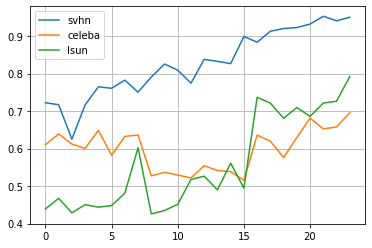

In [11]:
x = range(len(xx))
plt.plot(x, df.loc[xx, 'svhn'], label='svhn')
plt.plot(x, df.loc[xx, 'celeba'], label='celeba')
plt.plot(x, df.loc[xx, 'lsun'], label='lsun')
plt.grid()
plt.legend()
